# Introduction to SNPE

<br/>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.append("../")
from common import MultivariateGaussianMDN, mog_log_prob, mog_sample

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [259]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi
from torch.utils import data
import numpy as np
from torch import tensor, ones, zeros, eye
from scipy.signal import argrelextrema
from sbi.utils import pairplot
from sbi.utils import BoxUniform
from torch.distributions import Normal
_ = torch.manual_seed(0)

In [6]:
from numpy import *
from scipy import integrate

### Define a simulator: Lotka-Volterra
Code taken from: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html

The Lotka-Volterra (aka Prey-Predator) model is a model that describes the evolution of the population of two spezies (e.g. foxes and rabbits). It is governed by the following two equations:

$\frac{du}{dt} = au - buv$  
$\frac{dv}{dt} = -cv + dbuv$

Let's assume that we observe the evolution of the population and we want to infer the parameters $a$ and $b$ (for simplicity, we will assume that $c$ and $d$ are known).

<img src="figures/xo_lotka.png" alt="drawing" width="500"/>

In [112]:
t = linspace(0, 15,  1000)      # time
X0 = array([10, 5])             # initials conditions: 10 rabbits and 5 foxes

In [8]:
def run_model(theta):
    a = theta[0]
    b = theta[1]
    c = 1.5
    d = 0.75
    def dX_dt(X, t=0):
        return array([ a*X[0] -   b*X[0]*X[1] ,
                      -c*X[1] + d*b*X[0]*X[1] ])

    X, _ = integrate.odeint(dX_dt, X0, t, full_output=True)
    return X

In [9]:
X = run_model([1.0, 0.1])

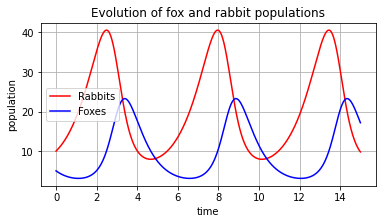

In [113]:
rabbits, foxes = X.T
f1 = plt.subplots(1, 1, figsize=(6, 3))
plt.plot(t, rabbits, 'r-', label='Rabbits')
plt.plot(t, foxes  , 'b-', label='Foxes')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations')
plt.savefig("figures/xo_lotka.png", dpi=200, bbox_inches="tight")

<img src="figures/xo_lotka.png" alt="drawing" width="400"/>

# Summary statistics

In principle, we can run SNPE on the raw trace (more on that later). However, it is often preferable to define summary statistics that are of interest and try reproducing only those. Here, we use the means, variances, autocorrelations, and cross-correlation of the two traces.

In [116]:
def old_summary_stats(trace):
    """Unused. This cell will be deleted."""
    # for local maxima
    rabbits_maxima_times = argrelextrema(trace[:, 0], np.greater)[0]
    foxes_maxima_times = argrelextrema(trace[:, 1], np.greater)[0]
    
    rabbits_times_diffs = np.mean(np.diff(rabbits_maxima_times))
    foxes_times_diffs = np.mean(np.diff(foxes_maxima_times))
    
    rabbits_maxima_values = trace[:, 0][rabbits_maxima_times]
    foxes_maxima_values = trace[:, 1][foxes_maxima_times]
    
    rabbits_av_max_val = np.mean(rabbits_maxima_values)
    foxes_av_max_val = np.mean(foxes_maxima_values)
    
    return np.asarray([np.mean([rabbits_times_diffs, foxes_times_diffs]), rabbits_av_max_val, foxes_av_max_val])

In [122]:
def summstats(trace):
    new1 = [np.mean(trace[:, 0])]
    new2 = [np.mean(trace[:, 1])]
    new3 = [np.var(trace[:, 0])]
    new4 = [np.var(trace[:, 1])]
    new5 = [np.correlate(trace[:, 0], trace[:, 0], "full")[100]]
    new6 = [np.correlate(trace[:, 0], trace[:, 0], "full")[200]]
    new7 = [np.correlate(trace[:, 1], trace[:, 1], "full")[100]]
    new8 = [np.correlate(trace[:, 1], trace[:, 1], "full")[200]]
    new9 = np.correlate(trace[:, 0], trace[:, 1])
    return np.concatenate([new1, new2, new3, new4, new5, new6, new7, new8, new9])

In [123]:
def simulate(theta):
    trace = run_model(theta)
    summ_stats = summstats(trace)
    return summ_stats

### Define a prior

In [126]:
l = 0.1
u = 3.0
lower_bound = [l, l]
upper_bound = [u, u]
prior = BoxUniform(lower_bound, upper_bound)

### Generate simulated data
We will run 500 simulations that will be used to train the conditional density estimator.

In [129]:
N = 500

thetas = prior.sample((N,))
xs = []
for theta in thetas:
    xs.append(simulate(theta))
xs = np.stack(xs)

In [130]:
xs_mean = np.nanmean(xs, axis=0)
xs_std = np.nanstd(xs, axis=0)

xs_zscored = (xs - xs_mean) / xs_std

theta_mean = torch.mean(thetas, dim=0)
theta_std = torch.std(theta, dim=0)
theta_zscored = (thetas - theta_mean) / theta_std

In [131]:
contains_no_nan = np.invert(np.any(np.isnan(xs_zscored), axis=1))
thetas_train = theta_zscored[contains_no_nan]
xs_train = xs_zscored[contains_no_nan]

xs_torch = torch.as_tensor(xs_train, dtype=torch.float32)

# Exercise 1: Train neural network to learn $p(\theta | x)$

In [132]:
dataset = data.TensorDataset(thetas_train, xs_torch)
train_loader = data.DataLoader(
    dataset, batch_size=50,
)
mdn = MultivariateGaussianMDN(
    features=2,
    hidden_net=nn.Sequential(
        nn.Linear(9, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
    ),
    num_components=1,
    hidden_features=10,
)

opt = optim.Adam(mdn.parameters(), lr=0.001)
for e in range(500):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        logits, means, variances = mdn.get_mixture_components(x_batch)
        out = mog_log_prob(theta_batch, logits, means, variances)
        loss = -out.sum()
        loss.backward()
        opt.step()

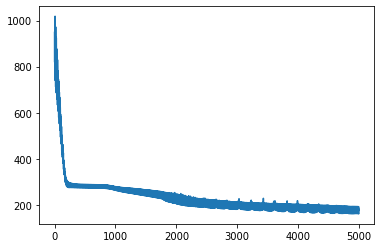

In [133]:
plt.plot(losses)

### Define an observation

In [471]:
gt = [1.0, 0.3]
xo = simulate(gt)

In [ ]:
xo_zscored = (xo - xs_mean) / xs_std
xo_torch = torch.as_tensor([xo_zscored], dtype=torch.float32)

### Draw samples from posterior

In [101]:
n = 500

logits, means, variances = mdn.get_mixture_components(xo_torch)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances))

In [102]:
samples = torch.cat(samples).detach()
samples = samples * theta_std + theta_mean

/home/michael/Documents/sbi/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(


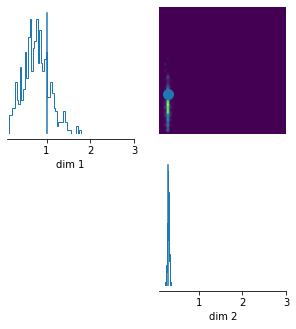

In [103]:
_ = pairplot(samples, limits=np.asarray([lower_bound, upper_bound]).T, points=[gt], figsize=(5, 5))

### Posterior predictive checks

In [104]:
gt_simulation = run_model(gt)
rabbits, foxes = gt_simulation.T

posterior_simulation = run_model(samples[0])
rabbits, foxes = posterior_simulation.T

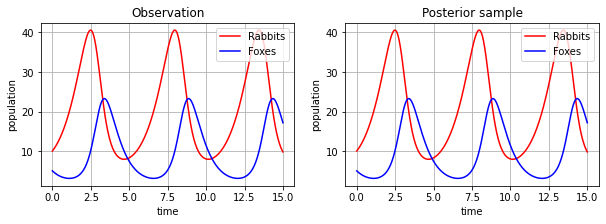

In [472]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(t, rabbits, 'r-', label='Rabbits')
ax[0].plot(t, foxes  , 'b-', label='Foxes')
ax[0].grid()
ax[0].legend(loc='best')
ax[0].set_xlabel('time')
ax[0].set_ylabel('population')
ax[0].set_title("Observation")

ax[1].plot(t, rabbits, 'r-', label='Rabbits')
ax[1].plot(t, foxes  , 'b-', label='Foxes')
ax[1].grid()
ax[1].legend(loc='best')
ax[1].set_xlabel('time')
ax[1].set_ylabel('population')
ax[1].set_title("Posterior sample")

plt.savefig("figures/post_predictives.png", dpi=200, bbox_inches="tight")

<img src="figures/post_predictives.png" alt="drawing" width="600"/>

# Exercise 2: Test amortization for a few different xo

### Amortization

In [475]:
gt2 = [2.0, 1.3]
xo2 = simulate(gt2)

xo_zscored2 = (xo2 - xs_mean) / xs_std
xo_torch2 = torch.as_tensor([xo_zscored2], dtype=torch.float32)

In [476]:
logits, means, variances = mdn.get_mixture_components(xo_torch2)

samples = []
for _ in range(n):
    samples.append(mog_sample(logits, means, variances)) 

samples = torch.cat(samples).detach()

In [477]:
samples = samples * theta_std + theta_mean

/home/michael/Documents/sbi/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(


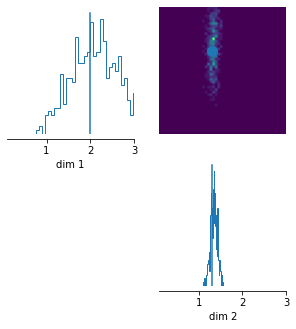

In [478]:
_ = pairplot(samples, limits=np.asarray([lower_bound, upper_bound]).T, points=[gt2], figsize=(5, 5))

In [479]:
gt_simulation = run_model(gt2)
rabbits, foxes = gt_simulation.T

posterior_simulation = run_model(samples[0])
rabbits, foxes = posterior_simulation.T

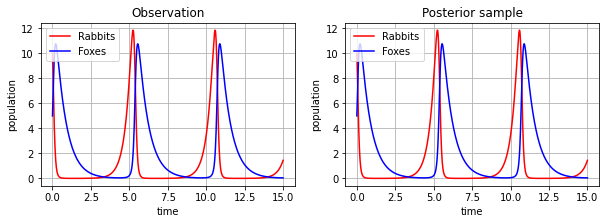

In [480]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(t, rabbits, 'r-', label='Rabbits')
ax[0].plot(t, foxes  , 'b-', label='Foxes')
ax[0].grid()
ax[0].legend(loc='best')
ax[0].set_xlabel('time')
ax[0].set_ylabel('population')
ax[0].set_title("Observation")

posterior_simulation = run_model(samples[0])
rabbits, foxes = posterior_simulation.T
ax[1].plot(t, rabbits, 'r-', label='Rabbits')
ax[1].plot(t, foxes  , 'b-', label='Foxes')
ax[1].grid()
ax[1].legend(loc='best')
ax[1].set_xlabel('time')
ax[1].set_ylabel('population')
ax[1].set_title("Posterior sample")
plt.savefig("figures/post_predictives2.png", dpi=200, bbox_inches="tight")

<img src="figures/post_predictives2.png" alt="drawing" width="600"/>

# Embedding network

One can pass the simulated data $x$ through **any** neural network before regressing on the Mixture Parameters (e.g. CNN, LSTM, GNN,...)

### Mixture Density Networks

<img src="../01_density_estimation/figures/architecture.png" alt="drawing" width="600"/>

The loss is now the probability under this mixture of Gaussians  <br/>

$L = -\sum_i \log p(t_i) = -\sum_i \log \sum_j \alpha_{j,i} N(t_i; \mu_{j,i}, \sigma_{j,i})$  <br/>

We learn the mixture components $\alpha_j$, the means $\mu_j$, and the variances $\sigma_j$.

# Focused (multi-round) inference

When drawing parameters from the prior and simulating them, we obtain $(\theta, x)$ from the joint distribution $p(\theta, x) \propto p(\theta) p(x|\theta)$.

In [335]:
def likelihood(theta):
    return theta*2.0 + torch.sin(theta*6) + torch.randn(theta.shape) * 0.3

In [336]:
prior = BoxUniform([0.0], [1.0,])
theta = prior.sample((1_000_000,))

In [338]:
x = likelihood(theta)

In [411]:
mat, _, _ = np.histogram2d(x.numpy()[:, 0], theta.numpy()[:, 0], bins=100, range=[[-1, 3], [0, 1]])

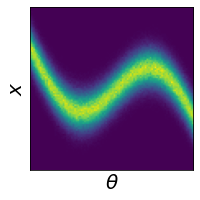

In [412]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
plt.savefig("figures/joint1.png", dpi=200, bbox_inches="tight")

A vertical "cut" through this joint density is the likelihood $p(x | \theta)$, whereas a horicontal cut is the posterior $p(\theta|x)$.

<img src="figures/fig1_Bayes.png" alt="drawing" width="400"/>

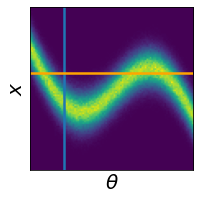

In [413]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat)
ax.plot([20, 20], [0, 99], linewidth=2.5)
ax.plot([0, 99], [40, 40], c="orange", linewidth=2.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
plt.savefig("figures/joint1_lines.png", dpi=200, bbox_inches="tight")

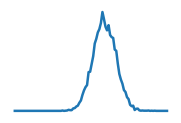

In [414]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(mat[:, 20], linewidth=2.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.savefig("figures/joint1_aid1.png", dpi=200, bbox_inches="tight")

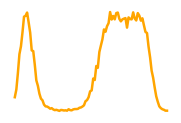

In [415]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(mat[40,:], c="orange", linewidth=2.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.savefig("figures/joint1_aid2.png", dpi=200, bbox_inches="tight")

But: what happens when our simulations are not sampled from the prior? Let's say that, instead of them being sampled from a uniform distribution (the prior), we sample them from a Gaussian:

<img src="figures/prior_illustration.png" alt="drawing" width="300"/>

In [416]:
proposal = Normal(0.75, 0.4)

In [417]:
prop_theta = proposal.sample((1_000_000,))

In [418]:
x_prop = likelihood(prop_theta)

In [419]:
mat_prop, _, _ = np.histogram2d(x_prop.numpy(), prop_theta.numpy(), bins=100, range=[[-1, 3], [0, 1]])

The data is now sampled from $\overline{p}(\theta, x) \propto \overline{p}(\theta)p(x|\theta)$

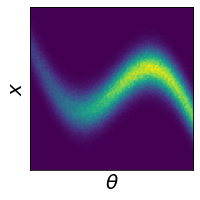

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat_prop)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
plt.savefig("figures/joint2.png", dpi=200, bbox_inches="tight")

Let's again inspect veritcal and horizontal "cuts".

<img src="figures/fig2_Bayes.png" alt="drawing" width="400"/>

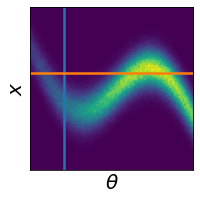

In [421]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(mat_prop)
ax.plot([20, 20], [0, 99], linewidth=2.5)
ax.plot([0, 99], [40, 40], linewidth=2.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$x$", fontsize=20.)
plt.savefig("figures/joint2_lines.png", dpi=200, bbox_inches="tight")

Let's compare to before:
<img src="figures/fig_Bayes_full.png" alt="drawing" width="1200"/>

Vertical cuts (i.e. the likelihood $p(x|\theta)$) stay the same, whereas horizontal cuts are now different. Thus, when naively training a conditional density estimator on data generated from the proposal, we will not converge to the true posterior distribution anymore.

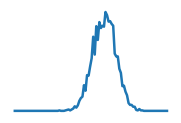

In [422]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(mat_prop[:, 20], linewidth=2.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.savefig("figures/joint2_aid1.png", dpi=200, bbox_inches="tight")

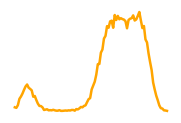

In [423]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(mat_prop[40, :], c="orange", linewidth=2.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.savefig("figures/joint2_aid2.png", dpi=200, bbox_inches="tight")

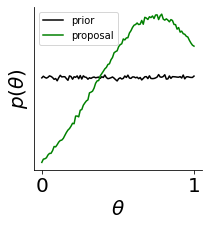

In [469]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
vals, _ = np.histogram(theta[:,0].numpy(), range=[0, 1], bins=100)
ax.plot(np.linspace(0, 1, 100), vals, c="k")
vals, _ = np.histogram(prop_theta.numpy(), range=[0, 1], bins=100)
ax.plot(np.linspace(0, 1, 100), vals*1.53, c="green")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(r"$\theta$", fontsize=20.)
ax.set_ylabel(r"$p(\theta)$", fontsize=20.)
ax.set_xticks([0,1])
ax.set_xticklabels([0, 1], fontsize=20.)
_ = ax.set_yticks([])
ax.legend(["prior", "proposal"])
plt.savefig("figures/prior_illustration.png", dpi=200, bbox_inches="tight")